In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..') # make sure modules can be found from project home directory

In [2]:
from src.data.data_loading import load_processed_dataset, load_raw_datasets

import pandas as pd
import geopandas as gpd
import numpy as np 
import matplotlib.pyplot as plt
# etc...

In [3]:
from tqdm import tqdm
tqdm.pandas()

### Loading raw fpa_fod data

In [4]:
df_list, df_names = load_raw_datasets('fpa_fod')


 Loading FPA_FOD_20210617 

Loading from sqlite database, this may take a while.
The list of dfs contains the following datasets (in this order): 
 ['FPA_FOD_20210617']


### First look at `fpa_fod`

In [5]:
fpa_fod = df_list[0].copy()
orig_shape = fpa_fod.shape

In [6]:
fpa_fod.dtypes

FOD_ID                             int64
FPA_ID                            object
SOURCE_SYSTEM_TYPE                object
SOURCE_SYSTEM                     object
NWCG_REPORTING_AGENCY             object
NWCG_REPORTING_UNIT_ID            object
NWCG_REPORTING_UNIT_NAME          object
SOURCE_REPORTING_UNIT             object
SOURCE_REPORTING_UNIT_NAME        object
LOCAL_FIRE_REPORT_ID              object
LOCAL_INCIDENT_ID                 object
FIRE_CODE                         object
FIRE_NAME                         object
ICS_209_PLUS_INCIDENT_JOIN_ID     object
ICS_209_PLUS_COMPLEX_JOIN_ID      object
MTBS_ID                           object
MTBS_FIRE_NAME                    object
COMPLEX_NAME                      object
FIRE_YEAR                          int64
DISCOVERY_DATE                    object
DISCOVERY_DOY                      int64
DISCOVERY_TIME                   float64
NWCG_CAUSE_CLASSIFICATION         object
NWCG_GENERAL_CAUSE                object
NWCG_CAUSE_AGE_C

In [7]:
fpa_fod.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,511,Plumas National Forest,1,...,1730.0,0.10,A,40.036944,-121.005833,USFS,CA,63,06063,Plumas County
1,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,13,...,1530.0,0.25,A,38.933056,-120.404444,USFS,CA,61,06061,Placer County
2,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,27,...,2024.0,0.10,A,38.984167,-120.735556,STATE OR PRIVATE,CA,17,06017,El Dorado County
3,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,43,...,1400.0,0.10,A,38.559167,-119.913333,USFS,CA,3,06003,Alpine County
4,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,503,Eldorado National Forest,44,...,1200.0,0.10,A,38.559167,-119.933056,USFS,CA,3,06003,Alpine County


#### Use the original coords (*LONGITUDE*, *LATITUDE*) to convert `fpa_fod` to a `GeoDataFrame` containing a `geometry` column

In [8]:
fpa_fod = gpd.GeoDataFrame(fpa_fod,geometry=gpd.points_from_xy(fpa_fod.LONGITUDE, fpa_fod.LATITUDE))
# The cols containing LONGITUDE and LATITUDE are no longer needed, so drop em
fpa_fod.drop(columns=['LONGITUDE', 'LATITUDE'], inplace=True, errors='ignore') 

<AxesSubplot:>

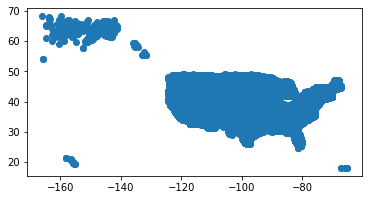

In [9]:
# plotting for all years is very resource intensive due to large number of rows; 2018 is most recent year
fpa_fod.loc[fpa_fod.FIRE_YEAR == 2018].plot()

The above plot doesn't provide much information, but we can clearly see the fires come from across the USA

## Cleaning `fpa_fod`
*Note: only the columns we care about will be cleaned*

### Change/update feature names

In [10]:
fpa_fod.rename( 
    columns=
    {
        'NWCG_GENERAL_CAUSE': 'SPECIFIC_CAUSE',
        'NWCG_CAUSE_CLASSIFICATION': 'GENERAL_CAUSE',
        'DISCOVERY_DATE': 'FIRE_DATE',
        'CONT_DATE': 'FIRE_CONT_DATE'
    }, 
    inplace=True
)

#### How are the different `CAUSE` features related wrt the data?

In [11]:
fpa_fod[['SPECIFIC_CAUSE', 'GENERAL_CAUSE']].value_counts()

SPECIFIC_CAUSE                              GENERAL_CAUSE                          
Debris and open burning                     Human                                      507219
Missing data/not specified/undetermined     Human                                      373550
Natural                                     Natural                                    312807
Arson/incendiarism                          Human                                      310320
Equipment and vehicle use                   Human                                      175824
Missing data/not specified/undetermined     Missing data/not specified/undetermined    173887
Recreation and ceremony                     Human                                       92725
Misuse of fire by a minor                   Human                                       64630
Smoking                                     Human                                       61689
Railroad operations and maintenance         Human                     

#### How about independently?

In [12]:
print(fpa_fod.SPECIFIC_CAUSE.value_counts(dropna=False), '\n')
print(fpa_fod.GENERAL_CAUSE.value_counts(dropna=False))

Missing data/not specified/undetermined       547438
Debris and open burning                       507219
Natural                                       312807
Arson/incendiarism                            310320
Equipment and vehicle use                     175824
Recreation and ceremony                        92725
Misuse of fire by a minor                      64630
Smoking                                        61689
Railroad operations and maintenance            36437
Power generation/transmission/distribution     28491
Fireworks                                      17205
Other causes                                    9763
Firearms and explosives use                     2205
Name: SPECIFIC_CAUSE, dtype: int64 

Human                                      1680058
Natural                                     312807
Missing data/not specified/undetermined     173887
NaN                                              1
Name: GENERAL_CAUSE, dtype: int64


### Change/update feature dtypes

In [13]:
fpa_fod[['FOD_ID', 'FIRE_YEAR']] = fpa_fod[['FOD_ID', 'FIRE_YEAR']].progress_apply(
    pd.to_numeric, downcast="unsigned")
fpa_fod['FIRE_SIZE'] = pd.to_numeric(fpa_fod['FIRE_SIZE'], downcast='float')

for col in ['GENERAL_CAUSE', 'SPECIFIC_CAUSE', 'FIRE_SIZE_CLASS', 'STATE']:
        fpa_fod[col] = fpa_fod[col].astype('category')

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]


In [14]:
fpa_fod[['FOD_ID', 'FIRE_YEAR', 'FIRE_SIZE', 'GENERAL_CAUSE', 
         'SPECIFIC_CAUSE', 'FIRE_SIZE_CLASS', 'STATE']].dtypes

FOD_ID               uint32
FIRE_YEAR            uint16
FIRE_SIZE           float32
GENERAL_CAUSE      category
SPECIFIC_CAUSE     category
FIRE_SIZE_CLASS    category
STATE              category
dtype: object

### Process `FIRE_DATE` feature

In [15]:
fpa_fod[['DISCOVERY_TIME', 'FIRE_DATE', 'FIRE_YEAR', 'DISCOVERY_DOY']].dtypes

DISCOVERY_TIME    float64
FIRE_DATE          object
FIRE_YEAR          uint16
DISCOVERY_DOY       int64
dtype: object

#### Do we have any null values for time related data?

In [16]:
fpa_fod[['DISCOVERY_TIME', 'FIRE_DATE', 'FIRE_YEAR', 'DISCOVERY_DOY']].isna().sum()

DISCOVERY_TIME    754468
FIRE_DATE              0
FIRE_YEAR              0
DISCOVERY_DOY          0
dtype: int64

#### Here is what the values of `DISCOVERY_TIME` *look like*

In [17]:
fpa_fod.DISCOVERY_TIME.head()

0    1300.0
1     845.0
2    1921.0
3    1600.0
4    1600.0
Name: DISCOVERY_TIME, dtype: float64

#### Handle null values in `DISCOVERY_TIME` before proceeding with processing `FIRE_DATE` feature

In [18]:
# convert to string so we can set the null values to '0000.0'
fpa_fod.DISCOVERY_TIME = fpa_fod.DISCOVERY_TIME.astype(str)
# null values are now the string 'nan'; get the index of these values
index = fpa_fod[fpa_fod.DISCOVERY_TIME == 'nan'].index
# update the null values to '0000.0'
fpa_fod.loc[index, 'DISCOVERY_TIME'] = '0000.0'

#### Quick sanity check

In [19]:
fpa_fod[fpa_fod.DISCOVERY_TIME == 'nan'].DISCOVERY_TIME

Series([], Name: DISCOVERY_TIME, dtype: object)

#### To be a valid time, there should be a minimum of 3 numbers to the left of the decimal sign. This means that strings with length **less than** 5 are invalid and can be set to `'0000.0'` instead

In [20]:
fpa_fod[fpa_fod.DISCOVERY_TIME.str.len() < 5].DISCOVERY_TIME.head()

96     15.0
275    50.0
407    34.0
466    50.0
975    30.0
Name: DISCOVERY_TIME, dtype: object

In [21]:
# get the index of the above values
index = fpa_fod[fpa_fod.DISCOVERY_TIME.str.len() < 5].index
# update the invalid time values to '0000.0'
fpa_fod.loc[index, 'DISCOVERY_TIME'] = '0000.0'

#### How many values remain that are not `'0000.0'`?

In [22]:
print(f"{fpa_fod[fpa_fod.DISCOVERY_TIME != '0000.0'].DISCOVERY_TIME.shape[0]} values remain \n")

1395500 values remain 



#### Quick check to ensure that the remaining times are within the valid 24 hour time range

In [23]:
print(fpa_fod.loc[lambda fpa_fod: fpa_fod.DISCOVERY_TIME.astype(float) < 0].DISCOVERY_TIME)
print(fpa_fod.loc[lambda fpa_fod: fpa_fod.DISCOVERY_TIME.astype(float) > 2400].DISCOVERY_TIME)

Series([], Name: DISCOVERY_TIME, dtype: object)
Series([], Name: DISCOVERY_TIME, dtype: object)


#### Now we can merge the features that are time related into one, unified `FIRE_DATE`

In [24]:
def insert_time_fpa_fod(row):
    time = pd.to_datetime(row['DISCOVERY_TIME'], format='%H%M')
    row['FIRE_DATE'] = row['FIRE_DATE'].replace(hour=time.hour, minute=time.minute)
    return row

In [25]:
# convert columns to string before applying to_datetime function
fpa_fod = fpa_fod.astype({'FIRE_YEAR': 'str', 'DISCOVERY_DOY': 'str'})

# process date of fire
fpa_fod['FIRE_DATE'] = pd.to_datetime(
    fpa_fod['FIRE_YEAR'] + ' ' + fpa_fod['DISCOVERY_DOY'], format='%Y %j', utc=True)

# remove the .0 from each DISCOVERY_TIME so that they are in correct %H%M format
fpa_fod['DISCOVERY_TIME'] = fpa_fod['DISCOVERY_TIME'].str[:-2]

# process time of fire
fpa_fod = fpa_fod.progress_apply(lambda row: insert_time_fpa_fod(row), axis=1)

100%|████████████████████████████████████████████████████████████████████| 2166753/2166753 [09:46<00:00, 3695.73it/s]


### Process `FIRE_CONT_DATE` feature

In [26]:
fpa_fod[['CONT_TIME', 'FIRE_CONT_DATE', 'FIRE_YEAR', 'CONT_DOY']].dtypes

CONT_TIME         float64
FIRE_CONT_DATE     object
FIRE_YEAR          object
CONT_DOY          float64
dtype: object

#### Notice there are far more null values for this time related data compared to `FIRE_DATE`

In [27]:
fpa_fod[['CONT_TIME', 'FIRE_CONT_DATE', 'FIRE_YEAR', 'CONT_DOY']].isna().sum()

CONT_TIME         933151
FIRE_CONT_DATE    854553
FIRE_YEAR              0
CONT_DOY          854553
dtype: int64

#### Notice that there are `854553` null values in both `FIRE_CONT_DATE` and `CONT_DOY`. Are they occuring in the same rows?

In [28]:
fpa_fod[fpa_fod.FIRE_CONT_DATE.isna() & fpa_fod.CONT_DOY.isna()].shape[0]

854553

#### The above values match (`854553`), so we can assume they are occuring in the same rows. `FIRE_CONT_DATE` cannot be determined for these rows. 

#### We can fill the null values in `CONT_DOY` with a nonsensical value for DOY, `400.0`, which will allow the column to be properly converted to int. 

#### Also, we need to consider the edge case where `CONT_DOY` is less than `DISCOVERY_DOY`. If this occurs, we need to ensure that the year value of `FIRE_CONT_DATE` is updated (+1 year).

In [29]:
print(f"CONT_DOY dtype before: {fpa_fod.CONT_DOY.dtype}")
fpa_fod = fpa_fod.fillna(value={'CONT_DOY': 400.0})
fpa_fod.CONT_DOY = pd.to_numeric(fpa_fod.CONT_DOY, downcast='integer')
print(f"CONT_DOY dtype after: {fpa_fod.CONT_DOY.dtype}")

CONT_DOY dtype before: float64
CONT_DOY dtype after: int16


#### Since we filled the null values with `400.0`, we need to check if `CONT_DOY` is *strictly less than* `DISCOVERY_DOY` for any fires. This information will be used to create the `FIRE_CONT_YEAR` column and will be dropped once `FIRE_CONT_DATE` is correctly processed.

In [30]:
index = fpa_fod[fpa_fod['DISCOVERY_DOY'].astype(int) > fpa_fod['CONT_DOY'].astype(int)].index
fpa_fod['FIRE_CONT_YEAR'] = fpa_fod['FIRE_YEAR'].astype(int)
fpa_fod.loc[index, 'FIRE_CONT_YEAR'] = fpa_fod.loc[index, 'FIRE_CONT_YEAR'].astype(int) + 1

#### Here is what the values of `CONT_TIME` *look like*

In [31]:
fpa_fod.CONT_TIME.head()

0    1730.0
1    1530.0
2    2024.0
3    1400.0
4    1200.0
Name: CONT_TIME, dtype: float64

#### Handle null values in `CONT_TIME` before proceeding with processing `FIRE_CONT_DATE` feature

In [32]:
# convert to string so we can set the null values to '0000.0'
fpa_fod.CONT_TIME = fpa_fod.CONT_TIME.astype(str)
# null values are now the string 'nan'; get the index of these values
index = fpa_fod[fpa_fod.CONT_TIME == 'nan'].index
# update the null values to '0000.0'
fpa_fod.loc[index, 'CONT_TIME'] = '0000.0'

#### Quick sanity check

In [33]:
print(fpa_fod[fpa_fod.CONT_TIME == 'nan'].CONT_TIME)

Series([], Name: CONT_TIME, dtype: object)


#### To be a valid time, there should be a minimum of 3 numbers to the left of the decimal sign. This means that strings with length **less than** 5 are invalid and can be set to `'0000.0'` instead

In [34]:
fpa_fod[fpa_fod.CONT_TIME.str.len() < 5].CONT_TIME.head()

96     45.0
553     5.0
560    10.0
719    30.0
728    30.0
Name: CONT_TIME, dtype: object

In [35]:
# get the index of the above values
index = fpa_fod[fpa_fod.CONT_TIME.str.len() < 5].index
# update the invalid time values to '0000.0'
fpa_fod.loc[index, 'CONT_TIME'] = '0000.0'

#### How many values remain that are not `'0000.0'`?

In [36]:
print(f"{fpa_fod[fpa_fod.CONT_TIME != '0000.0'].CONT_TIME.shape[0]} values remain \n")

1218783 values remain 



#### Quick check to ensure that the remaining times are within the valid 24 hour time range

In [37]:
print(fpa_fod.loc[lambda fpa_fod: fpa_fod.CONT_TIME.astype(float) < 0].CONT_TIME)
print(fpa_fod.loc[lambda fpa_fod: fpa_fod.CONT_TIME.astype(float) > 2400].CONT_TIME)

Series([], Name: CONT_TIME, dtype: object)
Series([], Name: CONT_TIME, dtype: object)


#### Now we can merge the features that are time related into one, unified `FIRE_CONT_DATE`. We have to be more cautious compared to the `FIRE_DATE`, since `DISCOVERY_DOY` had no null values but `CONT_DOY` has several null values. These dates can not be used, and we will set them to `NaT`

In [38]:
def insert_time_fpa_fod_cont(row):
    time = pd.to_datetime(row['CONT_TIME'], format='%H%M')
    row['FIRE_CONT_DATE'] = row['FIRE_CONT_DATE'].replace(hour=time.hour, minute=time.minute)
    return row

#### Setting `errors='coerce'` ensures that the `400` values in CONT_DOY will cause `FIRE_CONT_DATE` to be set to `NaT`

In [39]:
# convert columns to string before applying to_datetime function
fpa_fod = fpa_fod.astype({'FIRE_CONT_YEAR':'str', 'CONT_DOY': 'str'})

# process date of fire (contained)
fpa_fod['FIRE_CONT_DATE'] = pd.to_datetime(
    fpa_fod['FIRE_CONT_YEAR'] + ' ' + fpa_fod['CONT_DOY'], format='%Y %j',
    utc=True, errors='coerce')

# remove the .0 from each CONT_TIME so that they are in correct %H%M format
fpa_fod['CONT_TIME'] = fpa_fod['CONT_TIME'].str[:-2]

# process time of fire (contained)
fpa_fod = fpa_fod.progress_apply(lambda row: insert_time_fpa_fod_cont(row), axis=1)

100%|████████████████████████████| 2166753/2166753 [09:53<00:00, 3648.38it/s]


In [40]:
fpa_fod.tail().FIRE_CONT_DATE

2166748   NaT
2166749   NaT
2166750   NaT
2166751   NaT
2166752   NaT
Name: FIRE_CONT_DATE, dtype: datetime64[ns, UTC]

In [41]:
# always drop DOY and TIME after cleaning up both FIRE_CONT_DATE and FIRE_DATE
fpa_fod.drop(columns=['CONT_DOY', 'CONT_TIME','DISCOVERY_DOY', 'DISCOVERY_TIME'
                     , 'FIRE_CONT_YEAR'], inplace=True)

### Check null values for columns we *care about*

In [42]:
keep_cols = ['FOD_ID', 'FIRE_YEAR', 'FIRE_DATE', 'FIRE_CONT_DATE', 'GENERAL_CAUSE',
             'SPECIFIC_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'STATE']

In [43]:
for col in keep_cols: 
    print(f"{col} has {fpa_fod[col].isna().sum()} null values")

FOD_ID has 0 null values
FIRE_YEAR has 0 null values
FIRE_DATE has 0 null values
FIRE_CONT_DATE has 854553 null values
GENERAL_CAUSE has 1 null values
SPECIFIC_CAUSE has 0 null values
FIRE_SIZE has 0 null values
FIRE_SIZE_CLASS has 0 null values
STATE has 0 null values


#### `GENERAL_CAUSE` is the only column that has a null value (we will not drop rows where `FIRE_CONT_DATE` is `NaT`

In [44]:
fpa_fod.fillna({'GENERAL_CAUSE': 'Missing data/not specified/undetermined'}, inplace=True)
print(fpa_fod.GENERAL_CAUSE.value_counts(dropna=False))

Human                                      1680058
Natural                                     312807
Missing data/not specified/undetermined     173888
Name: GENERAL_CAUSE, dtype: int64


#### Now that `FIRE_DATE` is nicely formatted and has *datetime64 dtype*, we can use it as the index of the DataFrame

In [45]:
# sorting the index allows for better data slicing
fpa_fod = fpa_fod.set_index('FIRE_DATE').sort_index()

## View newly cleaned (!) dataframe and its attributes

In [46]:
fpa_fod.head()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,NWCG_CAUSE_AGE_CATEGORY,FIRE_CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,geometry
FIRE_DATE,,,,,,,,,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,878172,SCHMIDT_56005192,NONFED,ST-WYWYS,ST/C&L,USWYWYS,Wyoming State Forestry,WYWYS,Wyoming State Forestry,None,...,None,NaT,5.0,B,MISSING/NOT SPECIFIED,WY,Albany,56001,Albany County,POINT (-105.35980 42.01045)
1992-01-01 00:00:00+00:00,1100723,TFS_FL_54676,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS5,FLS Perry District,None,...,None,NaT,4.0,B,MISSING/NOT SPECIFIED,FL,Lafayette,12067,Lafayette County,POINT (-83.03000 29.98000)
1992-01-01 00:00:00+00:00,1100722,TFS_FL_54675,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS5,FLS Perry District,None,...,None,NaT,8.0,B,MISSING/NOT SPECIFIED,FL,Dixie,12029,Dixie County,POINT (-83.21000 29.54000)
1992-01-01 00:00:00+00:00,878247,SCHMIDT_56046592,NONFED,ST-WYWYS,ST/C&L,USWYWYS,Wyoming State Forestry,WYWYS,Wyoming State Forestry,None,...,None,NaT,8.0,B,MISSING/NOT SPECIFIED,WY,Goshen,56015,Goshen County,POINT (-104.19750 41.73458)
1992-01-01 00:00:00+00:00,846971,SC_26961,NONFED,ST-SCSCS,ST/C&L,USSCSCS,South Carolina Forestry Commission,SCSCS,South Carolina Forestry Commission,None,...,None,1992-01-01 11:22:00+00:00,4.0,B,MISSING/NOT SPECIFIED,SC,43,45085,Sumter County,POINT (-80.27917 33.92083)


In [47]:
fpa_fod.tail()

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,NWCG_CAUSE_AGE_CATEGORY,FIRE_CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,geometry
FIRE_DATE,,,,,,,,,,,,,,,,,,,,,
2018-12-31 23:20:00+00:00,400472945,SFO-2018AZPHX201810823,NONFED,ST-NASF,ST/C&L,USAZPHX,Phoenix Fire Department,AZPHX,Phoenix Fire Department,None,...,None,2018-12-31 23:34:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-112.22634 33.47175)
2018-12-31 23:46:00+00:00,400375295,SFO-2018CACDFSCU181434,NONFED,ST-NASF,ST/C&L,USCACDF,California Department of Forestry & Fire Prote...,CACDF,"Headquarters, California Department of Forestr...",None,...,None,NaT,0.01,A,MISSING/NOT SPECIFIED,CA,ALAMEDA,06001,Alameda County,POINT (-121.71741 37.71438)
2018-12-31 23:47:00+00:00,400480891,SFO-2018AZPHX201810824,NONFED,ST-NASF,ST/C&L,USAZPHX,Phoenix Fire Department,AZPHX,Phoenix Fire Department,None,...,None,2019-01-01 00:00:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-112.11263 33.52908)
2018-12-31 23:52:00+00:00,400479171,SFO-2018AZPHX201810825,NONFED,ST-NASF,ST/C&L,USAZPHX,Phoenix Fire Department,AZPHX,Phoenix Fire Department,None,...,None,2019-01-01 00:00:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-112.21023 33.49478)
2018-12-31 23:59:00+00:00,400478615,SFO-2018AZTMP201810826,NONFED,ST-NASF,ST/C&L,USAZTMP,Tempe Fire Department,AZTMP,Tempe Fire Department,None,...,None,2019-01-01 00:00:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-111.88318 33.41199)


In [48]:
fpa_fod.dtypes

FOD_ID                                         int64
FPA_ID                                        object
SOURCE_SYSTEM_TYPE                            object
SOURCE_SYSTEM                                 object
NWCG_REPORTING_AGENCY                         object
NWCG_REPORTING_UNIT_ID                        object
NWCG_REPORTING_UNIT_NAME                      object
SOURCE_REPORTING_UNIT                         object
SOURCE_REPORTING_UNIT_NAME                    object
LOCAL_FIRE_REPORT_ID                          object
LOCAL_INCIDENT_ID                             object
FIRE_CODE                                     object
FIRE_NAME                                     object
ICS_209_PLUS_INCIDENT_JOIN_ID                 object
ICS_209_PLUS_COMPLEX_JOIN_ID                  object
MTBS_ID                                       object
MTBS_FIRE_NAME                                object
COMPLEX_NAME                                  object
FIRE_YEAR                                     

In [49]:
fpa_fod.isna().sum()

FOD_ID                                 0
FPA_ID                                 0
SOURCE_SYSTEM_TYPE                     0
SOURCE_SYSTEM                          0
NWCG_REPORTING_AGENCY                  0
NWCG_REPORTING_UNIT_ID                 0
NWCG_REPORTING_UNIT_NAME               0
SOURCE_REPORTING_UNIT                  0
SOURCE_REPORTING_UNIT_NAME             0
LOCAL_FIRE_REPORT_ID             1701854
LOCAL_INCIDENT_ID                 734948
FIRE_CODE                        1797096
FIRE_NAME                         939607
ICS_209_PLUS_INCIDENT_JOIN_ID    2135993
ICS_209_PLUS_COMPLEX_JOIN_ID     2165833
MTBS_ID                          2153848
MTBS_FIRE_NAME                   2153848
COMPLEX_NAME                     2161081
FIRE_YEAR                              0
GENERAL_CAUSE                          0
SPECIFIC_CAUSE                         0
NWCG_CAUSE_AGE_CATEGORY          2093127
FIRE_CONT_DATE                    854553
FIRE_SIZE                              0
FIRE_SIZE_CLASS 

#### Convert features to `category` type again since they are object still ...

In [50]:
for col in ['GENERAL_CAUSE', 'SPECIFIC_CAUSE', 'FIRE_SIZE_CLASS', 'STATE']:
        fpa_fod[col] = fpa_fod[col].astype('category')

In [51]:
fpa_fod.dtypes

FOD_ID                                         int64
FPA_ID                                        object
SOURCE_SYSTEM_TYPE                            object
SOURCE_SYSTEM                                 object
NWCG_REPORTING_AGENCY                         object
NWCG_REPORTING_UNIT_ID                        object
NWCG_REPORTING_UNIT_NAME                      object
SOURCE_REPORTING_UNIT                         object
SOURCE_REPORTING_UNIT_NAME                    object
LOCAL_FIRE_REPORT_ID                          object
LOCAL_INCIDENT_ID                             object
FIRE_CODE                                     object
FIRE_NAME                                     object
ICS_209_PLUS_INCIDENT_JOIN_ID                 object
ICS_209_PLUS_COMPLEX_JOIN_ID                  object
MTBS_ID                                       object
MTBS_FIRE_NAME                                object
COMPLEX_NAME                                  object
FIRE_YEAR                                     

#### Done, now the DataFrame can be saved as a .pkl object. The file is roughly 600 MB and can be downloaded from the [data](https://drive.google.com/drive/folders/18YlVzuPCf-IXeQQSy0F3H32oG_KHEBhr?usp=sharing) folder

In [52]:
fpa_fod.to_pickle('clean_fpa_fod_all.pkl')

In [53]:
fpa_fod

,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,...,NWCG_CAUSE_AGE_CATEGORY,FIRE_CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,geometry
FIRE_DATE,,,,,,,,,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,878172,SCHMIDT_56005192,NONFED,ST-WYWYS,ST/C&L,USWYWYS,Wyoming State Forestry,WYWYS,Wyoming State Forestry,None,...,None,NaT,5.00,B,MISSING/NOT SPECIFIED,WY,Albany,56001,Albany County,POINT (-105.35980 42.01045)
1992-01-01 00:00:00+00:00,1100723,TFS_FL_54676,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS5,FLS Perry District,None,...,None,NaT,4.00,B,MISSING/NOT SPECIFIED,FL,Lafayette,12067,Lafayette County,POINT (-83.03000 29.98000)
1992-01-01 00:00:00+00:00,1100722,TFS_FL_54675,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS5,FLS Perry District,None,...,None,NaT,8.00,B,MISSING/NOT SPECIFIED,FL,Dixie,12029,Dixie County,POINT (-83.21000 29.54000)
1992-01-01 00:00:00+00:00,878247,SCHMIDT_56046592,NONFED,ST-WYWYS,ST/C&L,USWYWYS,Wyoming State Forestry,WYWYS,Wyoming State Forestry,None,...,None,NaT,8.00,B,MISSING/NOT SPECIFIED,WY,Goshen,56015,Goshen County,POINT (-104.19750 41.73458)
1992-01-01 00:00:00+00:00,846971,SC_26961,NONFED,ST-SCSCS,ST/C&L,USSCSCS,South Carolina Forestry Commission,SCSCS,South Carolina Forestry Commission,None,...,None,1992-01-01 11:22:00+00:00,4.00,B,MISSING/NOT SPECIFIED,SC,43,45085,Sumter County,POINT (-80.27917 33.92083)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:20:00+00:00,400472945,SFO-2018AZPHX201810823,NONFED,ST-NASF,ST/C&L,USAZPHX,Phoenix Fire Department,AZPHX,Phoenix Fire Department,None,...,None,2018-12-31 23:34:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-112.22634 33.47175)
2018-12-31 23:46:00+00:00,400375295,SFO-2018CACDFSCU181434,NONFED,ST-NASF,ST/C&L,USCACDF,California Department of Forestry & Fire Prote...,CACDF,"Headquarters, California Department of Forestr...",None,...,None,NaT,0.01,A,MISSING/NOT SPECIFIED,CA,ALAMEDA,06001,Alameda County,POINT (-121.71741 37.71438)
2018-12-31 23:47:00+00:00,400480891,SFO-2018AZPHX201810824,NONFED,ST-NASF,ST/C&L,USAZPHX,Phoenix Fire Department,AZPHX,Phoenix Fire Department,None,...,None,2019-01-01 00:00:00+00:00,0.10,A,MISSING/NOT SPECIFIED,AZ,Maricopa,04013,Maricopa County,POINT (-112.11263 33.52908)
